# COGS 108 - Final Project 

# Overview

The goal of this project is to use a dataset provided by Yelp, which contains information on restaurant ratings, review counts, ZIP codes, and average price, to predict a given restaurant's Yelp score. The predicted yelp score will be determined using the previous factors, specifically the positive reviews, the greater amount of review counts, all with using the location of the restaurant with the zip codes provided in the data set.

# Name & GitHub

- Name: Mher Arabian
- GitHub Username: A11364327

# Research Question

How well does a restaurant's review count, ZIP code, and average price, predict a restaurant's Yelp score?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1) https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/wi15/Wa'el_Farhan.pdf
- 2) https://pdfs.semanticscholar.org/43c5/6af59062ac41031ef80b5853cc323a20be26.pdf

# Hypothesis


Given a restaurant's review count, ZIP code, and average price, we can accurately predict its Yelp score.

# Dataset(s)


- Dataset Name: yelp.csv
- Link to the dataset: provided as part of assignment
- Number of observations: 3688

This is a dataset of Yelp restaurant reviews, containing restaurant names, address, ratings, review counts, ZIP codes, average price, and cuisine they serve, among other features. 

# Setup

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Data Cleaning

In [67]:
# load dataset
df = pd.read_csv("data/yelp.csv")

# drop rows with missing values
df = df.dropna()

# drop features that are not of interest
df = df.drop(['is_closed', 'address1', 'latitude', 'longitude', 'phone', 'name'], axis=1)
df = df.reset_index(drop=True)

print(df.shape)
df.head()


(2891, 25)


,id,rating,review_count,zip_code,price,hotdogs,sandwiches,pizza,tradamerican,burgers,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
0,luciano-pizzeria-ristorante-northwest-raleigh,5.0,2,27612,$,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,olive-garden-italian-restaurant-wilson,3.0,16,27893,$$,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,subway-wilson-4,3.5,3,27896,$,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,trent-restaurant-pollocksville,5.0,5,28573,$$$,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,bailey-cafe-bailey-2,4.5,10,27807,$,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
# drop rest of columns we don't need
cols = list(range(5, 25))
df.drop(df.columns[cols],axis=1,inplace=True)

In [69]:
df

,id,rating,review_count,zip_code,price
0,luciano-pizzeria-ristorante-northwest-raleigh,5.0,2,27612,$
1,olive-garden-italian-restaurant-wilson,3.0,16,27893,$$
2,subway-wilson-4,3.5,3,27896,$
3,trent-restaurant-pollocksville,5.0,5,28573,$$$
4,bailey-cafe-bailey-2,4.5,10,27807,$
...,...,...,...,...,...
2886,carter-finley-stadium-raleigh,3.5,23,27607,19198344000
2887,raleigh-little-theatre-raleigh,3.5,24,27607,19198213111
2888,sky-zone-trampoline-park-durham-durham,4.0,12,27701,19194250800
2889,highgrove-estate-fuquay-varina,3.5,4,27526,19195526154


Convert $ signs in price column to numerical form (1-4). Also remove observations with no dollar signs in price column.

In [70]:
for row, item in enumerate(df['price']):
    if item == '$':
        df.at[row, 'price'] = 1.0
    elif item == '$$':
        df.at[row, 'price'] = 2.0
    elif item == '$$$':
        df.at[row, 'price'] = 3.0
    elif item == '$$$$':
        df.at[row, 'price'] = 4.0
    else:
        df.drop(index=row, inplace=True)

In [71]:
df.head()

,id,rating,review_count,zip_code,price
0,luciano-pizzeria-ristorante-northwest-raleigh,5.0,2,27612,1
1,olive-garden-italian-restaurant-wilson,3.0,16,27893,2
2,subway-wilson-4,3.5,3,27896,1
3,trent-restaurant-pollocksville,5.0,5,28573,3
4,bailey-cafe-bailey-2,4.5,10,27807,1


In [72]:
print("Number of observations in dataset after cleaning data:", df.shape[0])

Number of observations in dataset after cleaning data: 2857


In [73]:
print("Number of features in dataset after cleaning data:", df.shape[1]-2)

Number of features in dataset after cleaning data: 3


# Data Visualization

Text(0, 0.5, 'frequency')

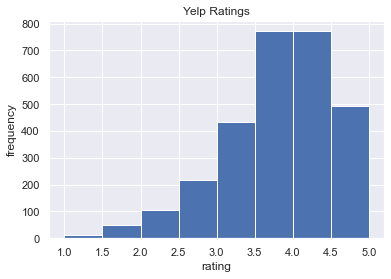

In [74]:
plot_ratings = df.hist(column='rating', bins=8)
plt.title('Yelp Ratings')
plt.xlabel('rating')
plt.ylabel('frequency')

The histogram above shows that the majority of restaurant ratings on Yelp fall between the 3.5-4.5 range.

Text(0, 0.5, 'frequency')

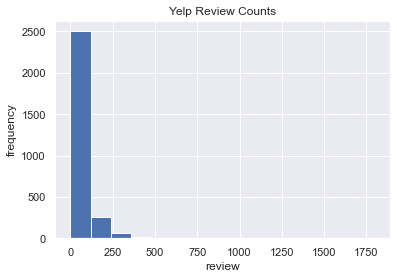

In [75]:
plot_reviews = df.hist(column='review_count', bins=15)
plt.title('Yelp Review Counts')
plt.xlabel('review')
plt.ylabel('frequency')

The histogram above shows that most restaurants have between 0-125 reviews. A small number of restaurant's have more than 250 reviews.

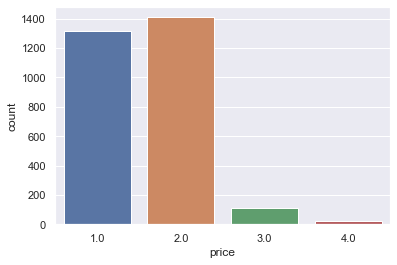

In [76]:
p = sns.countplot(data=df, x = 'price')

The bar plot above shows that most restaurants have or \$$ or \$ as their average price (2 and 1 numerically).

# Data Analysis & Results

### Simple linear regression with one variable (review count) to predict restaurant Yelp rating.

In [83]:
# training set
X = df['review_count']
y = df['rating']

In [84]:
model_review = sm.OLS(y, X).fit()
predictions = model_review.predict(X) # make the predictions by the model
# Print out the statistics
model_review.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.299
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              1217.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                   1.86e-222
Time:                        23:23:35   Log-Likelihood:                         -7248.1
No. Observations:                2857   AIC:                                  1.450e+04
Df Residuals:                    2856   BIC:                                  1.450e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
review_count     0.0188      0.001     34.889      0.000       0.018       0.020
==============================================================================
Omnibus:                     2961.321   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           394296.908
Skew:                          -4.801   Prob(JB):                         0.00
Kurtosis:                      59.745   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient of correlation **R** is 0.54, which means there is a positive correlation between a restaurant's review count and rating.

### Simple linear regression with one variable (price) to predict restaurant Yelp rating.

In [88]:
# training set
X = df['price']
y = df['rating']

In [89]:
model_price = sm.OLS(y, X.astype(float)).fit()
predictions = model_price.predict(X) # make the predictions by the model
# Print out the statistics
model_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                          1.646e+04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                        0.00
Time:                        23:23:56   Log-Likelihood:                         -5025.0
No. Observations:                2857   AIC:                                  1.005e+04
Df Residuals:                    2856   BIC:                                  1.006e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price          1.9813      0.015    128.278      0.000       1.951       2.012
==============================================================================
Omnibus:                       88.652   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.748
Skew:                          -0.393   Prob(JB):                     4.88e-23
Kurtosis:                       3.496   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient of correlation **R** is 0.92, which means there is a strong positive correlation between a restaurant's average price and rating.

### Multiple linear regression with three variable (review count, price, zip code) to predict restaurant Yelp rating.

In [100]:
# training set
X = df[['review_count', 'zip_code', 'price']][0:2286]
y = df['rating'][0:2286]

# test set
X_test = df[['review_count', 'zip_code', 'price']][2286:]
y_test = df['rating'][2286:]

In [101]:

model_multiple = sm.OLS(y, X.astype(float)).fit()
predictions = model_multiple.predict(X)
model_multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.765e+04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                        0.00
Time:                        23:36:57   Log-Likelihood:                         -2566.2
No. Observations:                2286   AIC:                                      5138.
Df Residuals:                    2283   BIC:                                      5156.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
review_count     0.0014      0.000      7.781      0.000       0.001       0.002
zip_code         0.0001    1.6e-06     74.955      0.000       0.000       0.000
price            0.1178      0.026      4.449      0.000       0.066       0.170
==============================================================================
Omnibus:                       61.129   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.499
Skew:                          -0.402   Prob(JB):                     5.99e-15
Kurtosis:                       3.203   Cond. No.                     4.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficient of correlation **R** is 0.979, which means there is a very strong positive correlation between the three features: **review count**, **zip code**, **price** and a restaurant's rating.

## Test the model with test set

In [115]:
predictions_test = model_multiple.predict(X_test)

In [116]:
# this function compares predictions and labels and returns the accuracy of model
def check_accuracy(predictions, labels):
    num_accurate = 0
    for pred, label in zip(predictions, labels):
        if round(pred*2)/2 == label:
            num_accurate += 1
            
    return num_accurate/len(predictions)

Get accuracy of model on test set

In [117]:
accuracy = check_accuracy(predictions_test, y_test)
print(accuracy)

0.29246935201401053


**Accuracy of model on test set is 0.3%** This means we cannot accurately predict a restaurant's Yelp rating based on review counts, zip code, and average price.

# Ethics & Privacy

We should consider that restaurants may be negatively affected by this analysis. The predicted score by the model for a given restauarant does not necessarily reflect its actual Yelp rating, or whether or not it is a good/bad restaurant.

# Conclusion & Discussion

The question that was sought to be answered was whether or not a restaurant’s review count, zip code, and the price could be used to predict its yelp scores. From the collection of data sets and data analysis, it was proven that these variables could not be used to predict. The accuracy of the test set was 0.3%, which means that we cannot predict the restaurant’s rating.

The regression model that was used, however, did give strong correlation values. Between review count and yelp score, the correlation value was 0.54 which could be assumed to have some correlation, but for the price, a correlation of 0.92, nearly a perfectly positive correlation was found. However, we know that correlation is not causation, and the test set was used to figure out if the price, zip code, and a restaurant’s review count could be used to predict yelp reviews. So overall, the hypothesis was proven wrong.